In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn import linear_model
%matplotlib inline
import mwviews
from bs4 import BeautifulSoup
import requests
from mwviews.api import PageviewsClient

### Scraping class

In [14]:
class scrape_title_info:
    def __init__(self):
        self.wiki_titles = []
        self.wiki_urls = []
        self.list_dicts = []
        self.wiki_api_titles = []
        self.title_list = []
        self.rottentomatoes_scores = []
        self.metacritic_scores = []
        self.bomojo_info = []

    
    # fit function to run all other functions with status updates through process
    def fit(self,start_year,end_year):
        print('Getting links...')
        self.get_links(start_year,end_year)
        print('Getting wikipedia info from wiki pages...')
        self.get_wiki_info()
        print('Cleaning wikipedia urls...')
        self.clean_wiki_urls()
        print('Setting up early dataframes...')
        self.data_frames_early()
        print('Getting wikipedia search volume...')
        self.get_wiki_search_vol()
        print('Getting box office mojo information...')
        self.bomojo()
        print('Getting rottentomatoes scores...')
        self.get_rotten_tomatoes()
        print('Getting metacritic scores...')
        self.get_metacritics_score
        print('Setting up final dataframes...')
        self.data_frames_final()
        print('Completed!')
    
    
    def get_links(self,start_year,end_year):
        for year in range(start_year,end_year + 1):
            url = 'https://en.wikipedia.org/wiki/' + str(year) + '_in_film'
            result = requests.get(url)
            soup = BeautifulSoup(result.content)
            links = soup.find_all("table", { "class" : "wikitable sortable" })

            for link in links:
                for lin in link.find_all('i'):
                    for i in lin.find_all('a'):
                        self.wiki_titles.append(i.get_text())
                        self.wiki_urls.append(i.get('href'))
 

    def get_wiki_info(self):
        for url in self.wiki_urls:
            site_url = 'https://en.wikipedia.org/' + url 
            result = requests.get(site_url)
            soup = BeautifulSoup(result.content)
            info = soup.find_all('table', {'class': 'infobox'})

            # get category title like directed by, studio, boxoffice, etc.
            # categories differ by title/url so I can't just ask for the 5th or 6th element to get what I want
            category_info = []
            try:
                category = info[0].find_all('th', {'scope' : 'row'})
                for cat in category:
                    category_info.append(cat.get_text(strip=True))
            except:
                category_info.append(None)

            # get the actual information associated with each category
            summary_info = []
            try:
                information = info[0].find_all('td')[1:]
                for inf in information:
                    summary_info.append(inf.get_text('|',strip=True))
            except:
                summary_info.append(None)
            # add list items to dictionary to re-create structure from wikipedia
            dictionary = dict(zip(category_info, summary_info))
            dictionary['wiki_url'] = url 

            # get external links for bomojo, imdb, metacritic, rottentomatoes for each title and add it to dictionary
            ext_text = soup.find_all('a', {'class': 'external text'})
            ext_links = []
            for ext in ext_text:
                ext_links.append(ext.get('href'))

            # ad hoc way to parse out links for each title and site
            for link in ext_links:
                if 'mojo' in link:
                    if 'movies' in link:
                        dictionary['bomojo_link'] = link
                    else:
                        pass
                elif 'rottentomatoes' in link:
                    if 'editorial' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['rottentomatoes_link'] = link
                elif 'metacritic' in link:
                    if 'user' in link:
                        pass
                    elif 'imdb' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['metacritic_link'] = link
                elif 'imdb' in link:
                    if 'soundtrack' in link:
                        pass
                    elif 'metacritic' in link:
                        pass
                    elif 'rotten' in link:
                        pass
                    elif 'archive' in link:
                        pass
                    else:
                        dictionary['imdb_link'] = link
                else:
                    pass

            self.list_dicts.append(dictionary)  

    # remove wikipedia characters in url so the wiki api can read the titles appropriately
    def clean_wiki_urls(self):    
        for url in self.wiki_urls:
            org_url = url
            url = url.replace('%27', "'")
            url = url.replace('%26', '&')
            url = url.replace('%28', '(')
            url = url.replace('%29', ')')
            url = url.replace('%3F', '?')
            url = url.replace('%E2%80%93', '-')
            url = url.replace('%C3%A9', 'é')
            url = url.replace('%C3%A8', 'è')
            url = url.replace('%2C', ',')
            url = url.replace('%C4%97', 'ė')
            url = url.replace('%C3%A0', 'à')
            url = url.replace('%C3%BC', 'ü')
            url = url.replace('%C3%A1', 'á')
            self.wiki_api_titles.append((org_url,url[6:]))

    def data_frames_early(self):
        #create dataframe for wiki link and titles, not really needed, might remove
        self.df_wiki_links = pd.DataFrame({'wiki_title': self.wiki_titles,
                                           'wiki_url': self.wiki_urls})
        df_wiki_links_clean = pd.DataFrame(self.wiki_api_titles,columns=['org_wiki_url','clean_wiki_url'])
        self.df_wiki_links = self.df_wiki_links.merge(df_wiki_links_clean,left_on='wiki_url',right_on='org_wiki_url',how='left')
        self.df_wiki_links.to_csv('wikipedia_links.csv',sep=',',index=False)
        
        #create dataframe of wikipedia info, needed for bomojo, rottentomatoes and metacritic scrapes
        self.df_wiki_info = pd.DataFrame(self.list_dicts)
        self.df_wiki_info = self.df_wiki_info[['wiki_url','Country','Directed by','Distributed by',
                                               'Distributor','Genre','Produced by','Producer(s)',
                                               'Productioncompanies','Productioncompany','Productioncompany(s)',
                                               'Release date','Released','Length','Running time','Website',
                                               'Box office','Budget','Written by',
                                               'bomojo_link','imdb_link','metacritic_link', 'rottentomatoes_link']]
        self.df_wiki_info.merge(self.df_wiki_links,left_on='wiki_url',right_on='wiki_url',how='left')
        self.df_wiki_info.to_csv('wikipedia_page_info.csv',sep=',',index=False)
        # remove titles that don't have links to bomojo, rottentomatoes, and metacritic
        self.df_wiki_info = self.df_wiki_info.dropna(subset=['bomojo_link','rottentomatoes_link','metacritic_link'])
        
    
    # with clean urls, run each title through wikipedia api to get search volume
    def get_wiki_search_vol(self):
        p = PageviewsClient(user_agent="<person@organization.org> multiple movie titles")
        for title in self.df_wiki_links.clean_wiki_url:
            try:
                title_dict = p.article_views('en.wikipedia', title,start='19980101',end='20191231')
            except:
                None
            self.title_list.append(title_dict)

    # bomojo scrape to get film performance and cleaner release date
    # an issue with some titles where the initial info with release date, distributor, etc. is shifted
    # need to revisit to fix so as not to lose films like Avatar, Harry Potter 7, Lion King, and a few others
    def bomojo(self):
        for url in self.df_wiki_info.bomojo_link:
            try:
                result = requests.get(url)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'mp_box_content'})

                self.bomojo_info.append((url  #bomojo url as primary key
                                         ,soup.find_all('b')[1].get_text(strip=True) #title
                                        ,soup.find_all('b')[5].get_text(strip=True) #genre
                                        ,soup.find_all('b')[4].get_text(strip=True) #domestic release date
                                        ,soup.find_all('b')[7].get_text(strip=True) #rating
                                        ,figures[0].find_all('b')[1].get_text(strip=True) #domestic box office
                                        ,figures[0].find_all('b')[4].get_text(strip=True) #ww box office
                                        ,figures[1].find_all('td')[1].get_text(strip=True) #opening weekend dom box office
                                        ,figures[1].find_all('td')[7].get_text(strip=True))) # widest release # theaters
            except:
                self.bomojo_info.append((url, None, None, None, None, None, None, None, None))

                
    def get_rotten_tomatoes(self):
        self.rt_links = [link for link in list(self.df_wiki_info.rottentomatoes_link) if '/m/' in link]
        self.rt_links = set(self.rt_links) 
        
        for url in self.rt_links:
            if url.endswith("/"):
                url_top = url + 'reviews/?type=top_critics'
            else:
                url_top = url + '/reviews/?type=top_critics'
            try:
                result = requests.get(url_top)
                soup = BeautifulSoup(result.content)
                figures = soup.find_all('div', {'class': 'review_table'})

                names = figures[0].find_all('div', {'class': 'critic_name'}) # name of people and journal
                dates = figures[0].find_all('div',{'class': 'review_date subtle small'}) # review date
                review_icons = figures[0].find_all('div',{'class': 'review_icon'})

                for name, date, icon in zip(names,dates,review_icons):
                    name.find_all('a')
                    self.rottentomatoes_scores.append((url, name.get_text("|",strip=True),
                                                  date.get_text(strip=True),icon.get('class')[3]))
            except:
                self.rottentomatoes_scores.append((url, None, None, None))

        
    def get_metacritics_score():
        urls = list(set(self.df_wiki_info.metacritic_link))
        for url in urls:
            if url.endswith("/"):
                url_review = url + 'critic-reviews'
            else:
                url_review = url + '/critic-reviews'
            try:
                headers = {'User-Agent': 'Mozilla/5.0'}
                result = requests.get(url_review, headers=headers)
                soup = BeautifulSoup(result.content)

                scores = soup.find_all('div', {'class': 'metascore_w'}) 
                dates = soup.find_all('span', {'class': 'date'})

                for date, score in zip(dates,scores):
                    self.metacritic_scores.append((url, date.get_text(strip=True),score.get_text(strip=True)))
            except:
                self.metacritic_scores.append((url, None, None))
    
    def data_frames_final(self):
        df_wiki_search_vol = pd.concat([
            pd.DataFrame.from_dict(title_dict,orient='index')
            for title_dict in self.title_list
        ], axis=1,sort=False)
        df_wiki_search_vol.to_csv('wikipedia_search_volume.csv',index=True)
        
        df_bomojo = pd.DataFrame(data=self.bomojo_info,columns=['bomojo_url','bomojo_title','bomojo_genre', 
                                                   'bomojo_dom_releasedate','bomojo_mpaa_rating', 
                                                   'bomojo_dom_boxoffice','bomojo_ww_boxoffice', 
                                                   'bomojo_opwkd_dom_boxoffice','bomojo_numtheatres'])
        df_bomojo.to_csv('bomojo_data.csv',index=False)
        
        df_rottentomatoes = pd.DataFrame(data=self.rottentomatoes_scores, columns = ['rt_url','rt_critic|journal','rt_date','rt_review'])
        df_rottentomatoes.to_csv('rottentomatoes_score_data.csv',sep=',',index=False)
        
        df_metacritic = pd.DataFrame(data=self.metacritic_scores, columns=['mc_url','mc_date','mc_score'])
        df_metacritic.to_csv('metacritic_score_info.csv',sep=',',index=False)        

In [ ]:
scraper = scrape_title_info()
scraper.fit(2010,2018)

### Cleaning class

In [2]:
# import csv with wiki titles and urls
df_wiki_links = pd.read_csv('wikipedia_links.csv')
# import csv with wikipedia information, plus links to bomojo, RT, and metacritic
df_wiki_info = pd.read_csv('wikipedia_page_info.csv')

In [171]:
df_wiki_info.head()

,wiki_url,Country,Directed by,Distributed by,Distributor,Genre,Produced by,Producer(s),Productioncompanies,Productioncompany,...,Length,Running time,Website,Box office,Budget,Written by,bomojo_link,imdb_link,metacritic_link,rottentomatoes_link
0,/wiki/Franny%27s_Feet,NaN,Phoebe McAuley|George Buza|Katherine Crimi,NaN,Family Channel|(Canada)|Five|(United Kingdom),Gibson Hardie|Susin Nielsen,NaN,Paul Hunter,NaN,NaN,...,NaN,Decode Entertainment,NaN,NaN,NaN,Joanne Boreham,NaN,https://www.imdb.com/title/tt0380111/,NaN,NaN
1,/wiki/Olivia_(TV_series),NaN,NaN,NaN,NaN,Animated|Children,NaN,NaN,NaN,NaN,...,NaN,15–30 minutes,NaN,NaN,NaN,Jill Gorey,NaN,https://www.imdb.com/title/tt1458518/,NaN,NaN
2,/wiki/Franny%27s_Feet,NaN,Phoebe McAuley|George Buza|Katherine Crimi,NaN,Family Channel|(Canada)|Five|(United Kingdom),Gibson Hardie|Susin Nielsen,NaN,Paul Hunter,NaN,NaN,...,NaN,Decode Entertainment,NaN,NaN,NaN,Joanne Boreham,NaN,https://www.imdb.com/title/tt0380111/,NaN,NaN
3,/wiki/Sweetgrass_(film),United States,Lucien Castaing-Taylor,Cinema Guild,NaN,NaN,Ilisa Barbash,NaN,NaN,NaN,...,NaN,101 minutes,NaN,NaN,NaN,NaN,NaN,https://www.imdb.com/title/tt1517252/,http://www.metacritic.com/movie/sweetgrass,https://www.rottentomatoes.com
4,/wiki/Garbage_Dreams,English|Egyptian Arabic,Mai Iskander,NaN,NaN,NaN,Mai Iskander,NaN,NaN,NaN,...,NaN,United States,NaN,NaN,NaN,NaN,NaN,https://www.imdb.com/title/tt1344314/,NaN,https://www.rottentomatoes.com


In [3]:
# import csv file with wikipedia search volume for each title
df_wiki_search_vol = pd.read_csv('wikipedia_search_volume.csv',index_col=0)

In [174]:
df_wiki_search_vol.head()

,Franny's_Feet,Franny's_Feet.1,Olivia_(TV_series),Franny's_Feet.2,Franny's_Feet.3,Sweetgrass_(film),Garbage_Dreams,Stranger_Things_(film),Daybreakers,Leap_Year_(2010_film),...,Aquaman_(film),Bumblebee_(film),Welcome_to_Marwen,Cold_War_(2018_film),Second_Act_(film),Holmes_&_Watson,Vice_(2018_film),On_the_Basis_of_Sex,Destroyer_(2018_film),Black_Mirror:_Bandersnatch
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
avg_search_vol = df_wiki_search_vol.mean(axis=0)
max_search_vol = df_wiki_search_vol.max(axis=0)
median_search_vol = df_wiki_search_vol.median(axis=0)
std_search_vol = df_wiki_search_vol.std(axis=0)
df_search_features = pd.DataFrame({'avg_search_vol': avg_search_vol, 
                                   'max_search_vol': max_search_vol,
                                   'median_search_vol': median_search_vol,
                                   'std_search_vol': std_search_vol})

In [42]:
# feature: 1 month search volume, 6 months prior to release
# feature: 1 month search volume, 5 months prior to release
# feature: 1 month search volume, 4 months prior to release
# feature: 1 month search volume, 3 months prior to release
# feature: 1 month search volume, 2 months prior to release
# feature: 1 month search volume, 1 month prior to release
# feature: average growth / change % between 6 months above 

# feature: 1 week search volume, 4 weeks prior to release
# feature: 1 week search volume, 3 weeks prior to release
# feature: 1 week search volume, 2 weeks prior to release
# feature: 1 week search volume, 1 week prior to release
# feature: average growth / change % between 4 weeks above

# feature: search volume on the day 1 week before release

In [ ]:
# add release date from bomojo to df_wiki_search_vol


In [44]:
df_search_features = df_wiki_links.merge(df_search_features,left_on='clean_wiki_url',right_index=True,how='left')

In [46]:
df_search_features.head()

,wiki_title,wiki_url,org_wiki_url,clean_wiki_url,avg_search_vol,max_search_vol,median_search_vol,std_search_vol
0,Franny's Feet,/wiki/Franny%27s_Feet,/wiki/Franny%27s_Feet,Franny's_Feet,76.307336,326.0,73.0,20.002814
1,Franny's Feet,/wiki/Franny%27s_Feet,/wiki/Franny%27s_Feet,Franny's_Feet,76.307336,326.0,73.0,20.002814
2,Olivia,/wiki/Olivia_(TV_series),/wiki/Olivia_(TV_series),Olivia_(TV_series),139.642471,1238.0,129.0,55.105095
3,Franny's Feet,/wiki/Franny%27s_Feet,/wiki/Franny%27s_Feet,Franny's_Feet,76.307336,326.0,73.0,20.002814
4,Franny's Feet,/wiki/Franny%27s_Feet,/wiki/Franny%27s_Feet,Franny's_Feet,76.307336,326.0,73.0,20.002814


In [7]:
for film in list(df_wiki_search_vol.columns):
    if 'Star_Wars' in film:
        print(film)

Star_Wars:_Episode_I_-_The_Phantom_Menace
Star_Wars:_The_Force_Awakens
Star_Wars:_The_Last_Jedi
Solo:_A_Star_Wars_Story


In [140]:
# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('bomojo_data.csv')

In [141]:
df_bomojo.head(50)

,bomojo_url,bomojo_title,bomojo_genre,bomojo_dom_releasedate,bomojo_mpaa_rating,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres
0,https://www.boxofficemojo.com/movies/?id=daybr...,Daybreakers,Horror,"January 8, 2010",R,"$30,101,577","$51,416,464","$15,146,692","2,523 theaters"
1,http://www.boxofficemojo.com/movies/?id=leapye...,Leap Year,Romantic Comedy,"January 8, 2010",PG,"$25,918,920","$32,607,316","$9,202,815","2,512 theaters"
2,https://www.boxofficemojo.com/movies/?id=youth...,Youth in Revolt,Comedy,"January 8, 2010",R,"$15,281,286","$19,651,093","$6,888,334","1,873 theaters"
3,http://www.boxofficemojo.com/movies/?id=bitchs...,Bitch Slap,Action,"January 8, 2010",R,"$17,365","$199,436","$12,254",3 theaters
4,https://www.boxofficemojo.com/movies/?id=wonde...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,https://www.boxofficemojo.com/movies/?id=booko...,The Book of Eli,Action / Adventure,"January 15, 2010",R,"$94,835,059","$157,107,755","$32,789,494","3,111 theaters"
6,https://www.boxofficemojo.com/movies/?id=spyne...,The Spy Next Door,Action Comedy,"January 15, 2010",PG,"$24,307,086","$45,236,543","$9,726,056","2,924 theaters"
7,https://www.boxofficemojo.com/movies/?id=44inc...,44 Inch Chest,Drama,"January 15, 2010",R,"$39,033","$294,245","$4,185",5 theaters
8,https://www.boxofficemojo.com/movies/?id=fisht...,Fish Tank,Drama,"January 15, 2010",Unrated,"$374,675","$2,357,852","$25,854",15 theaters
9,https://www.boxofficemojo.com/movies/?id=crowl...,Extraordinary Measures,Drama,"January 22, 2010",PG,"$12,068,313","$15,134,293","$6,012,594","2,549 theaters"


In [142]:
# list(df_bomojo.bomojo_dom_releasedate)

In [143]:
df_bomojo.dtypes

bomojo_url                    object
bomojo_title                  object
bomojo_genre                  object
bomojo_dom_releasedate        object
bomojo_mpaa_rating            object
bomojo_dom_boxoffice          object
bomojo_ww_boxoffice           object
bomojo_opwkd_dom_boxoffice    object
bomojo_numtheatres            object
dtype: object

In [144]:
df_bomojo['bomojo_dom_releasedate'] = pd.to_datetime(df_bomojo['bomojo_dom_releasedate'],errors='coerce')

In [145]:
df_bomojo[df_bomojo.columns[5:8]] = df_bomojo[df_bomojo.columns[5:8]].replace('[\$,]', '', regex=True)
df_bomojo['bomojo_dom_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_dom_boxoffice'],errors='coerce')
df_bomojo['bomojo_ww_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_ww_boxoffice'],errors='coerce')
df_bomojo['bomojo_opwkd_dom_boxoffice'] = pd.to_numeric(df_bomojo['bomojo_opwkd_dom_boxoffice'],errors='coerce')

In [168]:
df_bomojo['bomojo_numtheatres_norm'] = df_bomojo['bomojo_numtheatres'].replace(' theaters', '', regex=True)
df_bomojo['bomojo_numtheatres_norm'] = df_bomojo['bomojo_numtheatres_norm'].replace(',', '', regex=True)
df_bomojo['bomojo_numtheatres_norm'] = pd.to_numeric(df_bomojo['bomojo_numtheatres_norm'],errors='coerce')

In [169]:
df_bomojo.head(150)

,bomojo_url,bomojo_title,bomojo_genre,bomojo_dom_releasedate,bomojo_mpaa_rating,bomojo_dom_boxoffice,bomojo_ww_boxoffice,bomojo_opwkd_dom_boxoffice,bomojo_numtheatres,bomojo_numtheatres_norm
0,https://www.boxofficemojo.com/movies/?id=daybr...,Daybreakers,Horror,2010-01-08,R,30101577.0,5.141646e+07,15146692.0,"2,523 theaters",2523.0
1,http://www.boxofficemojo.com/movies/?id=leapye...,Leap Year,Romantic Comedy,2010-01-08,PG,25918920.0,3.260732e+07,9202815.0,"2,512 theaters",2512.0
2,https://www.boxofficemojo.com/movies/?id=youth...,Youth in Revolt,Comedy,2010-01-08,R,15281286.0,1.965109e+07,6888334.0,"1,873 theaters",1873.0
3,http://www.boxofficemojo.com/movies/?id=bitchs...,Bitch Slap,Action,2010-01-08,R,17365.0,1.994360e+05,12254.0,3 theaters,3.0
4,https://www.boxofficemojo.com/movies/?id=wonde...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,https://www.boxofficemojo.com/movies/?id=booko...,The Book of Eli,Action / Adventure,2010-01-15,R,94835059.0,1.571078e+08,32789494.0,"3,111 theaters",3111.0
6,https://www.boxofficemojo.com/movies/?id=spyne...,The Spy Next Door,Action Comedy,2010-01-15,PG,24307086.0,4.523654e+07,9726056.0,"2,924 theaters",2924.0
7,https://www.boxofficemojo.com/movies/?id=44inc...,44 Inch Chest,Drama,2010-01-15,R,39033.0,2.942450e+05,4185.0,5 theaters,5.0
8,https://www.boxofficemojo.com/movies/?id=fisht...,Fish Tank,Drama,2010-01-15,Unrated,374675.0,2.357852e+06,25854.0,15 theaters,15.0
9,https://www.boxofficemojo.com/movies/?id=crowl...,Extraordinary Measures,Drama,2010-01-22,PG,12068313.0,1.513429e+07,6012594.0,"2,549 theaters",2549.0


In [175]:
df_bomojo.dtypes

bomojo_url                            object
bomojo_title                          object
bomojo_genre                          object
bomojo_dom_releasedate        datetime64[ns]
bomojo_mpaa_rating                    object
bomojo_dom_boxoffice                 float64
bomojo_ww_boxoffice                  float64
bomojo_opwkd_dom_boxoffice           float64
bomojo_numtheatres                    object
bomojo_numtheatres_norm              float64
dtype: object

In [49]:
# import csv file with ratings from both RT and metacritic
df_rottentomatoes = pd.read_csv('rottentomatoes_score_info.csv')
df_metacritic = pd.read_csv('metacritic_score_info.csv') 

In [50]:
df_rottentomatoes = pd.get_dummies(data=df_rottentomatoes, columns=['review'])

In [51]:
df_rottentomatoes_scores = df_rottentomatoes[['rt_url','review_fresh']].groupby(['rt_url'],as_index=False).mean()

In [52]:
# df_metacritic_scores = df_metacritic.groupby(['mc_url'],as_index=False).mean()

In [57]:
df_bo_predictor = df_wiki_info.merge(df_rottentomatoes_scores,left_on='rottentomatoes_link',right_on='rt_url',how='left')
# df_bo_predictor = df_bo_predictor.merge(df_metacritic_scores,left_on='metacritic_link',right_on='url',how='left')
df_bo_predictor = df_bo_predictor.merge(df_bomojo,left_on='bomojo_link',right_on='bomojo_url',how='left')
df_bo_predictor = df_bo_predictor.merge(df_search_features,left_on='wiki_url',right_on='wiki_url',how='left')

In [58]:
df_bo_predictor.describe()

,review_fresh,avg_search_vol,max_search_vol,median_search_vol,std_search_vol
count,2572.000000,3289.000000,3.289000e+03,3289.000000,3288.000000
mean,0.521252,1536.465088,2.797429e+04,976.999392,2098.443594
std,0.317846,3106.706774,8.642393e+04,1805.733109,5905.547107
min,0.000000,1.000000,1.000000e+00,1.000000,0.000000
25%,0.238095,235.987486,1.929000e+03,182.000000,135.022519
50%,0.565217,674.388417,7.056000e+03,526.000000,504.320061
75%,0.800000,1497.488803,2.018200e+04,1087.000000,1459.841184
max,1.000000,88430.500000,1.790893e+06,63901.000000,99892.467780


### Analyzing data

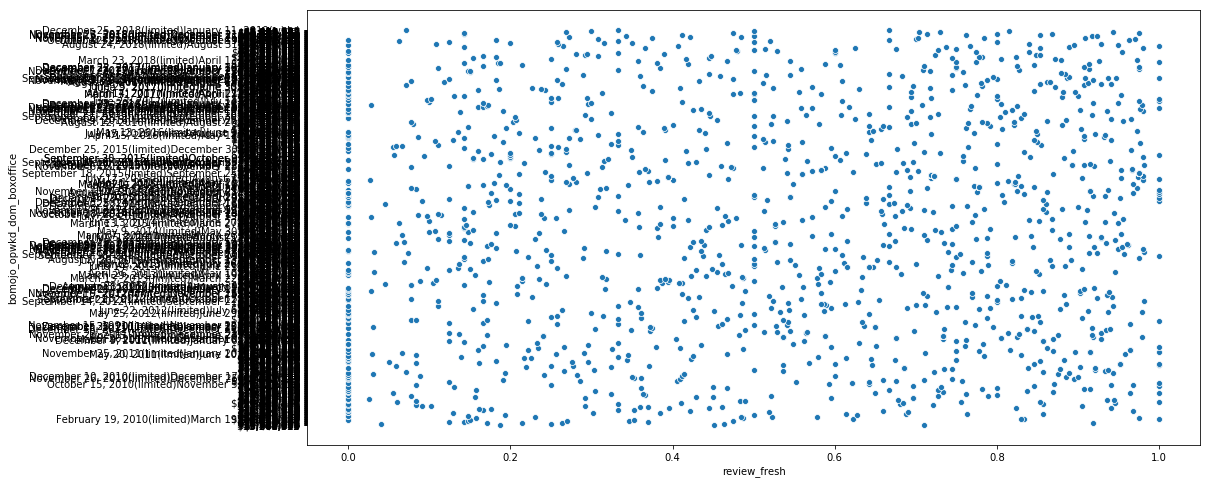

In [176]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='review_fresh',y='bomojo_opwkd_dom_boxoffice',data=df_bo_predictor)
plt.show()

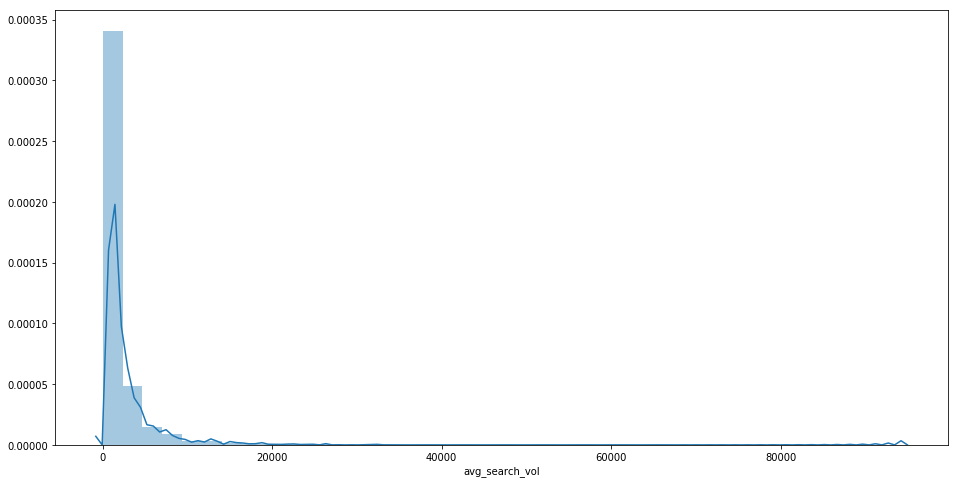

In [116]:
plt.figure(figsize=(16,8))
sns.distplot(df_search_features.avg_search_vol,bins=40)
plt.show()

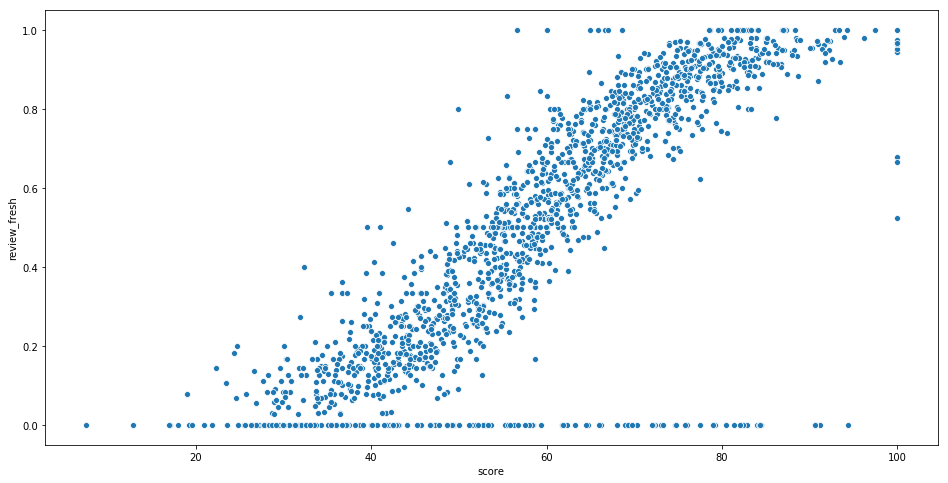

In [70]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='score',y='review_fresh',data=df_bo_predictor)
plt.show()

In [ ]:
# scores versus opening weekend and multiples

In [ ]:
X_train = 
y_train = 

X_test = 
y_test

### Multivariable Linear regression

In [ ]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(x, y))

In [ ]:
lr.score(X_test_reg,y_test_reg)
y_pred_reg = lr.predict(X_test_reg)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error: %.1f' % metrics.mean_absolute_error(y_test_reg, y_pred_reg))  
print('Mean Squared Error: %.1f' % metrics.mean_squared_error(y_test_reg, y_pred_reg))  
print('Root Mean Squared Error: %.1f' % np.sqrt(metrics.mean_squared_error(y_test_reg, y_pred_reg))) 

### Logistic regression